In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# Doing some basic numerical calculations that enter the bound.
Just to see how to balance factors against the right $\epsilon$s and $\delta$s so that we can actually get a reasonable result within $<1000000$ samples.

In [3]:
# input params
dim = np.array([2, 3, 6, 7, 10, 20, 22])  # common robot dofs.... 10 is base + arm, 20 is a PR2, 22 is a Movo
delta = np.array([0.5, 1.0]) #np.linspace(start=0.0, stop=1.0, num=5)[1:]
epsilon = np.linspace(start=0.0, stop=1.0, num=5)[1:]

def compute_vol_unit_sphere(_dim):
    return np.pi ** (_dim / 2) / scipy.special.gamma(_dim / 2 + 1)

def compute_vol_env(_delta, _dim):
    return (1.0 + 2 * _delta) * (2 * _delta) ** (_dim - 1) 

# some general helper methods to help us with our calculations
def compute_rho(_delta, _epsilon, _dim):
    """This is written a way that vectorized meshgrid computations can also be done."""
    _measures_unit_sphere = compute_vol_unit_sphere(_dim) / compute_vol_env(_delta, _dim)
    return _measures_unit_sphere * (_epsilon * _delta / np.sqrt(1 + _epsilon ** 2)) ** _dim

def compute_conn_rad(_delta, _epsilon):
    return 2 * (_epsilon + 1) * _delta / np.sqrt(1 + _epsilon ** 2)

def compute_measure_connection_ball(_delta, _epsilon, _dim):
    """This is written a way that vectorized meshgrid computations can also be done."""
    _measures_unit_sphere = compute_vol_unit_sphere(_dim) / compute_vol_env(_delta, _dim)
    conn_r = compute_conn_rad(_delta, _epsilon)
    return _measures_unit_sphere * conn_r ** _dim
    


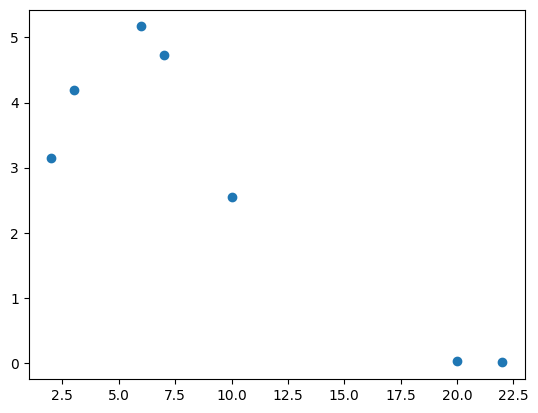

In [4]:
# https://en.wikipedia.org/wiki/Volume_of_an_n-ball
vol_unit_sphere = np.pi ** (dim / 2) / scipy.special.gamma(dim / 2 + 1)

plt.figure()
plt.scatter(dim, vol_unit_sphere)
plt.show()

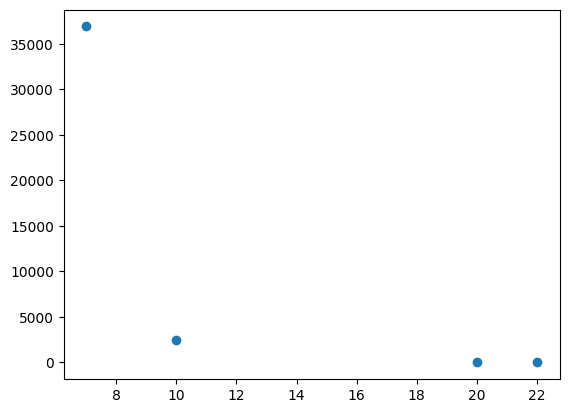

In [16]:
rad = 0.5
vol_rad_sphere = vol_unit_sphere * (rad ** dim) * 1e6

plt.figure()
plt.scatter(dim[3:], vol_rad_sphere[3:])
plt.show()


From this we learn there are environments where balls are exceedingly voluminous, and some where there are not. I suspect we will need to pick experiments wisely with respect to how this volume looks.

The bound has four variables that determine the sample complexity and probability of correctness: the dimension (influencing the VC-dimension of the unit balls), the measure of the unit ball, epsilon, and delta.

We now do a large vectorized computation to compute all the possible bound results. We won't actually use this computation for experiments, since we can use the tighter Sauer-Shelah bound anyway (numerically at least), but this is useful to see visually.

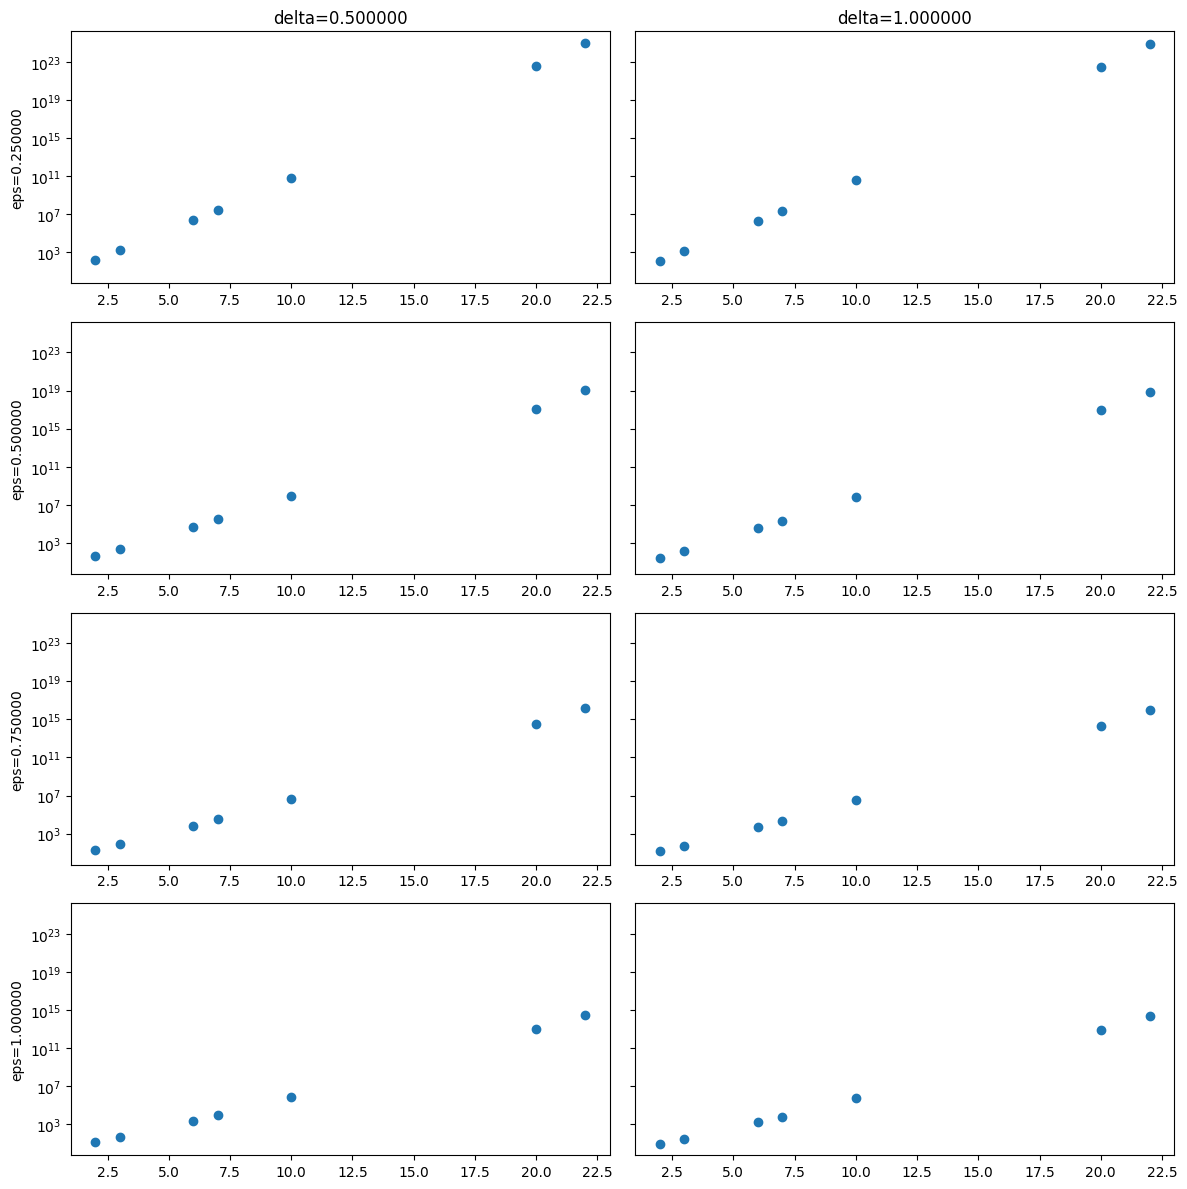

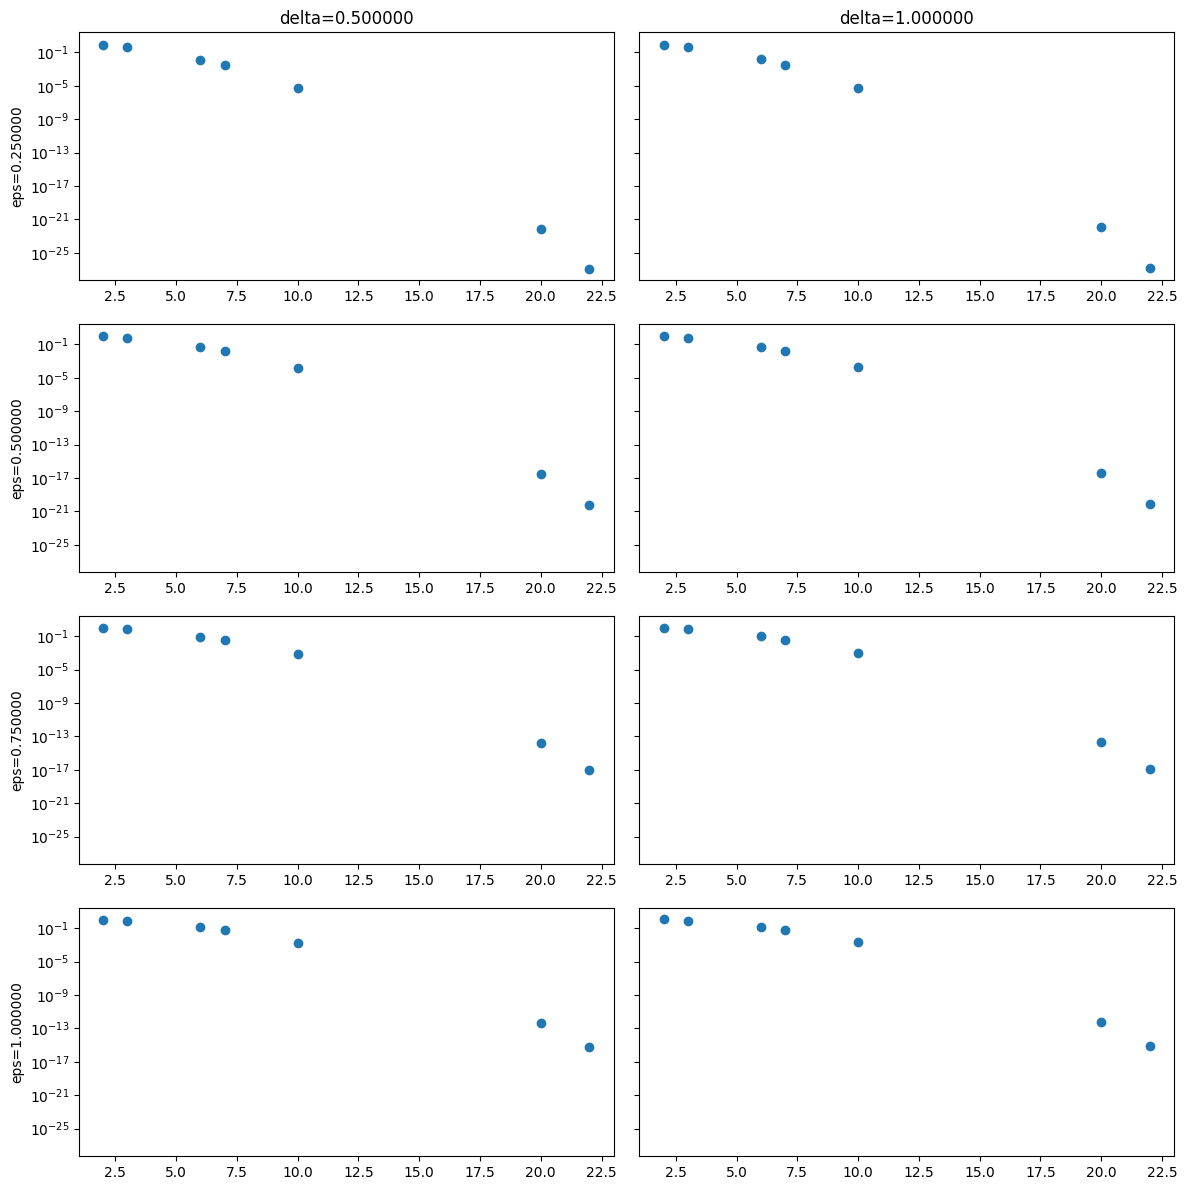

In [4]:
# first exploring the VC-dim threshold (this is Blumer's theory bound, which we won't end up using).
deltas, epsilons, dims = np.meshgrid(delta, epsilon, dim, indexing='ij')
rhos = compute_rho(deltas, epsilons, dims)

# compute number of samples needed for VC and their associated probabilities to see if they are even useful
big_o_constant = 0.025
base_vc_samples = 8 * (dims + 1) / rhos * np.log(13 / rhos) * big_o_constant
# base_gammas = 2 * (rhos / 13) ** (2 * (dims + 1)) # directly from max bound
base_gammas = 2 * np.exp(-rhos * base_vc_samples / 4)

# plot and ed-grid across dimensions
fig, axs = plt.subplots(nrows=len(epsilon), ncols=len(delta), figsize=(12, 12), sharey=True)
for ri in range(len(epsilon)):
    for ci in range(len(delta)):
        if ri == 0:
            axs[ri, ci].set_title('delta=%f' % delta[ci])

        if ci == 0:
            axs[ri, ci].set_ylabel('eps=%f' % epsilon[ri])

        axs[ri, ci].scatter(dim, base_vc_samples[ci, ri, :])
        axs[ri, ci].set_yscale('log')
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=len(epsilon), ncols=len(delta), figsize=(12, 12), sharey=True)
for ri in range(len(epsilon)):
    for ci in range(len(delta)):
        if ri == 0:
            axs[ri, ci].set_title('delta=%f' % delta[ci])

        if ci == 0:
            axs[ri, ci].set_ylabel('eps=%f' % epsilon[ri])

        axs[ri, ci].scatter(dim, base_gammas[ci, ri, :])
        axs[ri, ci].set_yscale('log')
fig.tight_layout()
plt.show()

In [5]:
# Designing tractable experiments by just evaluating well-defined bounds on the shatter function.
vc_dim = 6

m_sample = np.arange(1, 100000, step=100)

# Sauer-Shelah combinatorial sum bound
_m, _d = np.meshgrid(m_sample, np.arange(vc_dim + 1), indexing='xy')
ss_bound = np.sum(scipy.special.comb(_m, _d), axis=0)

# Folklore bound on Sauer shelah
flk_bound = (np.e * m_sample / vc_dim) ** vc_dim

plt.figure()
plt.plot(m_sample, ss_bound, label='sauer-shelah')
plt.plot(m_sample, flk_bound / 5, label='folklore')
plt.title('vc_dim = %i' % vc_dim)
plt.legend()
plt.show()

# it appears that these bounds are tight up to constants if you fix the dimension.
# even though it's harder to evaluate, we'll go with the original SS bound.

KeyboardInterrupt: 

In [14]:
# compute the sample response curves per dimension using sauer-shelah shatter bound. may be easiest to do numerical curve inversion
# failure probabilities
sample = np.arange(499900, 1000000, step=10)
deltas, epsilons, dims, samples = np.meshgrid(delta, epsilon, dim, sample, indexing='ij')

rhos = compute_rho(deltas, epsilons, dims)

# compute sauer-shelah bound factor
# this will be based on dims, and samples and will need to be reshaped for the meshgrid post-hoc.
ss_bounds_coll = []
for d in dim: 
    _m, _d = np.meshgrid(2 * sample, np.arange(d + 2))  # + 2 because VC-dim of nd spheres is d + 1
    ss_bound = np.sum(scipy.special.comb(_m, _d), axis=0)
    ss_bounds_coll.append(ss_bound)

ss_bounds = np.stack(ss_bounds_coll)
ss_bounds = np.repeat(ss_bounds[np.newaxis, :, :], len(epsilon), axis=0)
ss_bounds = np.repeat(ss_bounds[np.newaxis, :, :, :], len(delta), axis=0)

# finally, compute gamma
gammas = 2 * ss_bounds * np.exp2(-rhos * samples / 2)

for i_d, d in enumerate(dim):
    fig, axs = plt.subplots(nrows=len(epsilon), ncols=len(delta), figsize=(12, 12))
    for ri in range(len(epsilon)):
        for ci in range(len(dims)):
            if ri == 0:
                axs[ri, ci].set_title('delta=%f' % delta[ci])

            if ci == 0:
                axs[ri, ci].set_ylabel('eps=%f' % epsilon[ri])

            axs[ri, ci].plot(samples[ci, ri, i_d, :], gammas[ci, ri, i_d, :], label=str(d))

    axs[0, 0].legend()
plt.show(


TypeError: 'int' object is not iterable

We're running into issues where we are running out of memory. In the most memory case, OOM for computing graphs with 1024 neighbors for 1,000,000 points... which is 1024/2 * 1000,000 edges... 512000000 edges (e.g. ~~half billion). So this is a no go. We can either: truncate so we do _not_ reach this case, or try to design experiments that don't go this big. We'll opt to do both.

In [38]:
# cand_delta = np.array([0.0001, 0.25, 0.5, 0.75, 1.0])
# cand_epsilon = np.linspace(0.0, 0.5, num=100)[1:]
cand_delta = np.linspace(0.0, 1.0, num=9)[1:]
cand_epsilon = np.linspace(0.0, 1.0, num=10)[1:]
dim = 10
samples = 1e6

cand_deltas, cand_epsilons = np.meshgrid(cand_delta, cand_epsilon, indexing='ij')
compute_conn_rad(cand_deltas, cand_epsilons)
# compute_measure_connection_ball(cand_deltas, cand_epsilons, dim) * samples

# expected_number_of_neighbors = cand_mu_conn_ball 
# expected_number_of_neighbors

array([[0.27607882, 0.29827938, 0.31622777, 0.3299875 , 0.33995005,
        0.34668762, 0.35082321, 0.35294329, 0.35355339],
       [0.55215763, 0.59655876, 0.63245553, 0.65997501, 0.6799001 ,
        0.69337525, 0.70164642, 0.70588658, 0.70710678],
       [0.82823645, 0.89483814, 0.9486833 , 0.98996251, 1.01985016,
        1.04006287, 1.05246962, 1.05882987, 1.06066017],
       [1.10431526, 1.19311752, 1.26491106, 1.31995001, 1.35980021,
        1.38675049, 1.40329283, 1.41177316, 1.41421356],
       [1.38039408, 1.4913969 , 1.58113883, 1.64993752, 1.69975026,
        1.73343811, 1.75411604, 1.76471645, 1.76776695],
       [1.65647289, 1.78967628, 1.8973666 , 1.97992502, 2.03970031,
        2.08012574, 2.10493925, 2.11765974, 2.12132034],
       [1.93255171, 2.08795566, 2.21359436, 2.30991253, 2.37965036,
        2.42681336, 2.45576245, 2.47060303, 2.47487373],
       [2.20863052, 2.38623504, 2.52982213, 2.63990003, 2.71960041,
        2.77350098, 2.80658566, 2.82354632, 2.82842712]])